In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from shapely.geometry import Point
import shapely
# import folium
# from folium.plugins import MarkerCluster
import geopandas as gpd
from scipy.interpolate import griddata
import numpy as np
import os
import glob
# import rioxarray as rio
# import rasterio as rio
import rioxarray
import rasterio
from pyproj import Transformer
# from esda.moran import Moran
# from libpysal.weights import lat2W
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter
from skimage import filters
import rasterio
import rioxarray
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from pyproj import Transformer
from shapely.ops import nearest_points

In [5]:
file_path = "/Users/Azadeh/CRREL.xlsx"
sheet_name = 'Creamers' 
df_original_1 = pd.read_excel(file_path, sheet_name=sheet_name)

In [6]:
df_original_1.head()

,CF_Point,Point_ID,CF_Northing_m,CF_Easting_m,CF_Elev_m,CF_Dist_previous_m,CF_Dist_transect_m,CF_10_8_14,CF_09_29_15,CF_10_10_16,CF 10_2017,CF 10_5_2018,CF 10_15_19,CF 10_6_20,CF 10_2_21,CF_9_28_22,CF_Notes_22
0,1.0,Creamers-0001,7193915.511,465013.469,134.482,0.000000,0.000000,67.0,59.0,73.0,78.0,78.0,86.0,105.0,121.0,108.0,Thaw mounds; edge of TK
1,2.0,Creamers-0002,7193918.897,465011.682,134.302,3.828624,3.828624,70.0,57.0,64.0,59.0,69.0,69.0,79.0,69.0,73.0,Thaw mounds
2,3.0,Creamers-0003,7193923.281,465011.427,134.370,4.391410,8.220034,67.0,62.0,64.0,63.0,65.0,68.0,78.0,73.0,73.0,Thaw mounds
3,4.0,Creamers-0004,7193927.196,465011.460,134.202,3.915139,12.135173,72.0,72.0,69.0,67.0,67.0,73.0,77.0,64.0,70.0,Thaw mounds
4,5.0,Creamers-0005,7193930.739,465010.849,134.077,3.595298,15.730472,76.0,89.0,75.0,75.0,84.0,93.0,107.0,95.0,98.0,Thaw mounds


## Get the data for the color (add `color_value` to the dataframe from image)

In [7]:
xds = rioxarray.open_rasterio("/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif")

In [8]:
ndvi_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"
with rio.open(ndvi_file) as src:
    ndvi_band = src.read(1)
    transform = src.transform
    bounds = src.bounds
    crs = src.crs

In [9]:
coordinates_df = pd.read_excel("./CRREL.xlsx")
latitudes = coordinates_df['CF_Northing_m'].values
longitudes = coordinates_df['CF_Easting_m'].values
transformer = Transformer.from_crs("epsg:32606", crs.to_string(), always_xy=True)

In [10]:
def reproject_coordinates(x, y):
    return transformer.transform(x, y)

In [11]:
reprojected_coords = [reproject_coordinates(lon, lat) for lon, lat in zip(longitudes, latitudes)]

In [12]:
geometry = [Point(xy) for xy in reprojected_coords]
gdf = gpd.GeoDataFrame(coordinates_df, geometry=geometry, crs="epsg:32606")

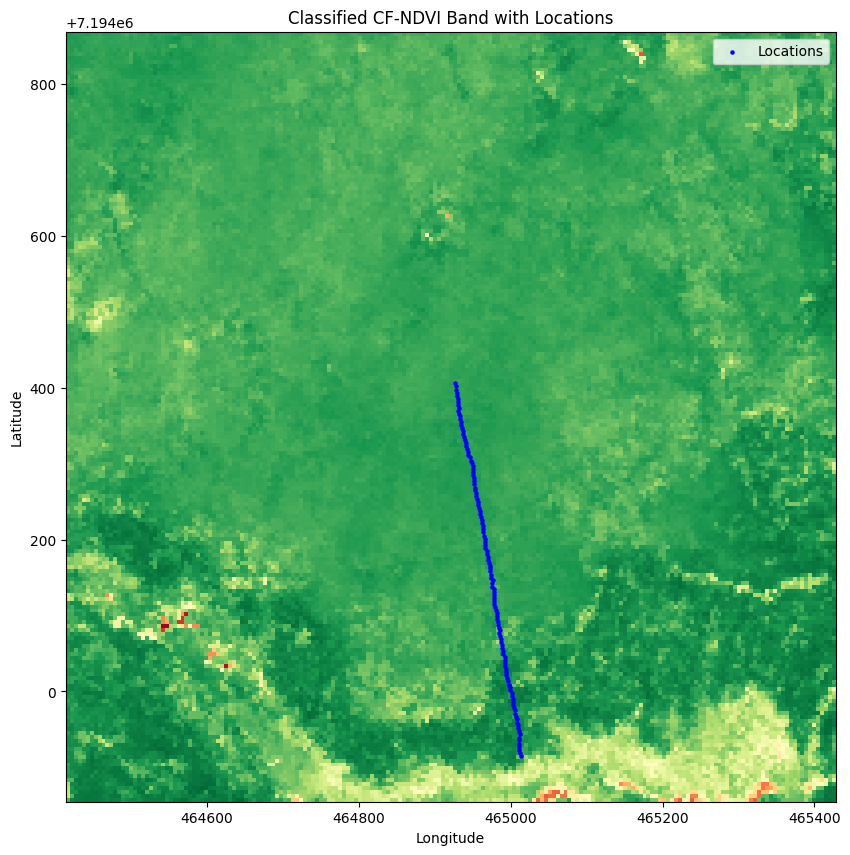

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(ndvi_band, cmap='RdYlGn', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
ax.set_title('Classified CF-NDVI Band with Locations')

gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label='Locations')

# ax.plot(126,126, marker='*', color='red', markersize=15, label='test')

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [14]:
x_coordinates_of_fig = np.linspace(bounds.left, bounds.right, ndvi_band.shape[0], endpoint=True).tolist()
y_coordinates_of_fig = np.linspace(bounds.bottom, bounds.top, ndvi_band.shape[1], endpoint=True).tolist()

In [15]:
dict_points_to_xyindices = {}
for i in range(len(x_coordinates_of_fig)):
    for j in range(len(y_coordinates_of_fig)):
        dict_points_to_xyindices[Point(x_coordinates_of_fig[i], y_coordinates_of_fig[j])] = (i,j)

In [16]:
list_of_coordinates_with_color_value = list(dict_points_to_xyindices.keys())

In [17]:
df_original_1.head()

,CF_Point,Point_ID,CF_Northing_m,CF_Easting_m,CF_Elev_m,CF_Dist_previous_m,CF_Dist_transect_m,CF_10_8_14,CF_09_29_15,CF_10_10_16,CF 10_2017,CF 10_5_2018,CF 10_15_19,CF 10_6_20,CF 10_2_21,CF_9_28_22,CF_Notes_22
0,1.0,Creamers-0001,7193915.511,465013.469,134.482,0.000000,0.000000,67.0,59.0,73.0,78.0,78.0,86.0,105.0,121.0,108.0,Thaw mounds; edge of TK
1,2.0,Creamers-0002,7193918.897,465011.682,134.302,3.828624,3.828624,70.0,57.0,64.0,59.0,69.0,69.0,79.0,69.0,73.0,Thaw mounds
2,3.0,Creamers-0003,7193923.281,465011.427,134.370,4.391410,8.220034,67.0,62.0,64.0,63.0,65.0,68.0,78.0,73.0,73.0,Thaw mounds
3,4.0,Creamers-0004,7193927.196,465011.460,134.202,3.915139,12.135173,72.0,72.0,69.0,67.0,67.0,73.0,77.0,64.0,70.0,Thaw mounds
4,5.0,Creamers-0005,7193930.739,465010.849,134.077,3.595298,15.730472,76.0,89.0,75.0,75.0,84.0,93.0,107.0,95.0,98.0,Thaw mounds


In [18]:
df_original_2 = df_original_1

for index, row in df_original_2.iterrows():
    df_original_2.loc[index, "geometry"] = Point(row["CF_Easting_m"], row["CF_Northing_m"])


In [19]:
dict_index_to_point = {}
dict_point_to_index = {}
for index, row in df_original_2.iterrows():
    dict_index_to_point[index] = row["geometry"]
    dict_point_to_index[row["geometry"]] = index

In [20]:
df_original = df_original_2

In [21]:
for index, row in df_original.iterrows():
    cur_location = row["geometry"]
    curr_list_distances = [shapely.distance(cur_location, list_of_coordinates_with_color_value[i]) for i in range(len(list_of_coordinates_with_color_value))]
    point_with_minimum_dist_to_curr_location = list_of_coordinates_with_color_value[np.argmin(curr_list_distances)]
    curr_x, curr_y = dict_points_to_xyindices[point_with_minimum_dist_to_curr_location]
    df_original.loc[index, "color_value"] = ndvi_band[curr_x, curr_y]

In [22]:
df_original.head()

,CF_Point,Point_ID,CF_Northing_m,CF_Easting_m,CF_Elev_m,CF_Dist_previous_m,CF_Dist_transect_m,CF_10_8_14,CF_09_29_15,CF_10_10_16,CF 10_2017,CF 10_5_2018,CF 10_15_19,CF 10_6_20,CF 10_2_21,CF_9_28_22,CF_Notes_22,geometry,color_value
0,1.0,Creamers-0001,7193915.511,465013.469,134.482,0.000000,0.000000,67.0,59.0,73.0,78.0,78.0,86.0,105.0,121.0,108.0,Thaw mounds; edge of TK,POINT (465013.469 7193915.511),0.747358
1,2.0,Creamers-0002,7193918.897,465011.682,134.302,3.828624,3.828624,70.0,57.0,64.0,59.0,69.0,69.0,79.0,69.0,73.0,Thaw mounds,POINT (465011.682 7193918.897),0.747358
2,3.0,Creamers-0003,7193923.281,465011.427,134.370,4.391410,8.220034,67.0,62.0,64.0,63.0,65.0,68.0,78.0,73.0,73.0,Thaw mounds,POINT (465011.427 7193923.281),0.724687
3,4.0,Creamers-0004,7193927.196,465011.460,134.202,3.915139,12.135173,72.0,72.0,69.0,67.0,67.0,73.0,77.0,64.0,70.0,Thaw mounds,POINT (465011.46 7193927.196),0.764184
4,5.0,Creamers-0005,7193930.739,465010.849,134.077,3.595298,15.730472,76.0,89.0,75.0,75.0,84.0,93.0,107.0,95.0,98.0,Thaw mounds,POINT (465010.849 7193930.739),0.762447


## Start training

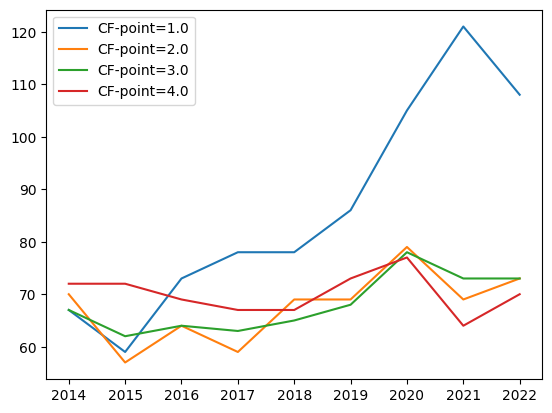

In [23]:
plt.plot([2014,2015,2016,2017,2018,2019,2020,2021,2022], df_original.iloc[0, 7:16], label="CF-point=1.0")
plt.plot([2014,2015,2016,2017,2018,2019,2020,2021,2022], df_original.iloc[1, 7:16], label="CF-point=2.0")
plt.plot([2014,2015,2016,2017,2018,2019,2020,2021,2022], df_original.iloc[2, 7:16], label="CF-point=3.0")
plt.plot([2014,2015,2016,2017,2018,2019,2020,2021,2022], df_original.iloc[3, 7:16], label="CF-point=4.0")
plt.legend()
plt.show()

In [24]:
list_column_to_be_scaled = ["CF_Northing_m","CF_Easting_m","CF_Elev_m","CF_Dist_previous_m","CF_Dist_transect_m","CF_10_8_14","CF_09_29_15","CF_10_10_16","CF 10_2017","CF 10_5_2018","CF 10_15_19","CF 10_6_20","CF 10_2_21","CF_9_28_22", "color_value"]

In [25]:
## scale the data
df = df_original
scaler = MinMaxScaler()
df[list_column_to_be_scaled] = scaler.fit_transform(df[list_column_to_be_scaled])

In [26]:
df.head()

,CF_Point,Point_ID,CF_Northing_m,CF_Easting_m,CF_Elev_m,CF_Dist_previous_m,CF_Dist_transect_m,CF_10_8_14,CF_09_29_15,CF_10_10_16,CF 10_2017,CF 10_5_2018,CF 10_15_19,CF 10_6_20,CF 10_2_21,CF_9_28_22,CF_Notes_22,geometry,color_value
0,1.0,Creamers-0001,0.000000,1.000000,0.123446,0.000000,0.000000,0.673129,0.572366,0.686464,0.712307,0.490052,0.519583,0.645109,0.855670,0.887324,Thaw mounds; edge of TK,POINT (465013.469 7193915.511),0.672406
1,2.0,Creamers-0002,0.006905,0.979461,0.071408,0.746546,0.007603,0.709448,0.547930,0.585685,0.502070,0.419444,0.393935,0.456799,0.319588,0.394366,Thaw mounds,POINT (465011.682 7193918.897),0.672406
2,3.0,Creamers-0003,0.015846,0.976530,0.091067,0.856283,0.016325,0.673129,0.609020,0.585685,0.546331,0.388062,0.386544,0.449557,0.360825,0.394366,Thaw mounds,POINT (465011.427 7193923.281),0.286850
3,4.0,Creamers-0004,0.023830,0.976909,0.042498,0.763415,0.024100,0.733661,0.731201,0.641673,0.590591,0.403753,0.423499,0.442314,0.268041,0.352113,Thaw mounds,POINT (465011.46 7193927.196),0.958540
4,5.0,Creamers-0005,0.031056,0.969886,0.006360,0.701049,0.031240,0.782086,0.938909,0.708860,0.679112,0.537124,0.571320,0.659594,0.587629,0.746479,Thaw mounds,POINT (465010.849 7193930.739),0.929015


In [27]:
df.iloc[:,18]

0      0.672406
1      0.672406
2      0.286850
3      0.958540
4      0.929015
         ...   
124    0.553758
125    0.553758
126    0.810991
127    0.810991
128    0.810991
Name: color_value, Length: 129, dtype: float64

In [28]:
num_locations, num_columns = df.shape
num_locations


129

In [29]:
num_locations = 126
data_for_training = []
num_past_years_as_feature = 2
for locale in range(num_locations):
    for start_year in range(2014, 2022):
        if start_year - 2007 + num_past_years_as_feature >= 16:
            break
        curr_features_in_train_data_point = [df.iloc[int(locale), 2], df.iloc[int(locale), 3], df.iloc[int(locale), 4], df.iloc[int(locale), 5], df.iloc[int(locale), 6], df.iloc[int(locale), 18]]
        curr_features_in_train_data_point.extend([df.iloc[int(locale), start_year - 2007 + i] for i in range(num_past_years_as_feature)])
        curr_target_in_train_data_point = [df.iloc[int(locale), start_year - 2007 + num_past_years_as_feature]]
        data_for_training.append([curr_features_in_train_data_point, curr_target_in_train_data_point])

In [30]:
data_for_training

[[[0.0,
   1.0,
   0.12344608268285384,
   0.0,
   0.0,
   0.6724062781287241,
   0.6731291402861106,
   0.5723659475960284],
  [0.6864641583684717]],
 [[0.0,
   1.0,
   0.12344608268285384,
   0.0,
   0.0,
   0.6724062781287241,
   0.5723659475960284,
   0.6864641583684717],
  [0.712307285574739]],
 [[0.0,
   1.0,
   0.12344608268285384,
   0.0,
   0.0,
   0.6724062781287241,
   0.6864641583684717,
   0.712307285574739],
  [0.49005206895042486]],
 [[0.0,
   1.0,
   0.12344608268285384,
   0.0,
   0.0,
   0.6724062781287241,
   0.712307285574739,
   0.49005206895042486],
  [0.5195826104806581]],
 [[0.0,
   1.0,
   0.12344608268285384,
   0.0,
   0.0,
   0.6724062781287241,
   0.49005206895042486,
   0.5195826104806581],
  [0.645108886373255]],
 [[0.0,
   1.0,
   0.12344608268285384,
   0.0,
   0.0,
   0.6724062781287241,
   0.5195826104806581,
   0.645108886373255],
  [0.8556701030927836]],
 [[0.0,
   1.0,
   0.12344608268285384,
   0.0,
   0.0,
   0.6724062781287241,
   0.645108886373

In [31]:
len(data_for_training)

882

In [32]:
num_locations = 126
data_for_evaluation = []
num_past_years_as_feature = 2
for locale in range(num_locations):
        curr_features_in_evaluation_data_point = [df.iloc[int(locale), 2], df.iloc[int(locale), 3], df.iloc[int(locale), 4], df.iloc[int(locale), 5], df.iloc[int(locale), 6], df.iloc[int(locale), 18]]
        curr_features_in_evaluation_data_point.extend([df.iloc[int(locale), 2022 - 2007 + i] for i in [-2,-1]])
        curr_target_in_evaluation_data_point = [df.iloc[int(locale), 2022 - 2007]]
        data_for_evaluation.append([curr_features_in_evaluation_data_point, curr_target_in_evaluation_data_point])

In [33]:
data_for_evaluation

[[[0.0,
   1.0,
   0.12344608268285384,
   0.0,
   0.0,
   0.6724062781287241,
   0.645108886373255,
   0.8556701030927836],
  [0.8873239436619718]],
 [[0.006905412572450587,
   0.9794607144503971,
   0.07140792136455332,
   0.7465455111074769,
   0.007603442571964183,
   0.6724062781287241,
   0.4567993158774312,
   0.3195876288659794],
  [0.3943661971830985]],
 [[0.015846147573029157,
   0.9765298147221984,
   0.09106678230702414,
   0.8562833516929355,
   0.016324546902586737,
   0.2868501504253267,
   0.44955664008913027,
   0.36082474226804123],
  [0.3943661971830985]],
 [[0.023830403395550093,
   0.9769091076277618,
   0.04249783174327604,
   0.7634150489631515,
   0.024099802927840478,
   0.9585397795924315,
   0.4423139643008294,
   0.26804123711340205],
  [0.352112676056338]],
 [[0.03105600195885927,
   0.9698864420033715,
   0.006360219716675886,
   0.7010491292802598,
   0.03123987237477947,
   0.9290152614805738,
   0.6595942379498569,
   0.5876288659793814],
  [0.746478873

In [48]:
# scaler.inverse_transform(data_for_training)

In [34]:
## Create X_train, y_trian
random.shuffle(data_for_training)

X_train = []
y_train = []
for curr_data_point in data_for_training:
    X_train.append(curr_data_point[0])
    y_train.append(curr_data_point[1])

In [35]:
## Create X_test, y_test
random.shuffle(data_for_evaluation)

X_test = []
y_test = []
for curr_data_point in data_for_evaluation:
    X_test.append(curr_data_point[0])
    y_test.append(curr_data_point[1])

In [36]:
import numpy as np

y_train = np.array(y_train)
y_test = np.array(y_test)

In [37]:
from sklearn.ensemble import RandomForestRegressor

# Define model
forest_reg = RandomForestRegressor(n_estimators = 50)

# Fit model
forest_reg.fit(X_train, y_train.ravel())

RandomForestRegressor(n_estimators=50)

In [38]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

In [39]:
# Compute mean-squared-error
final_mse = mean_squared_error(y_test.ravel() , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

0.04720489862798387

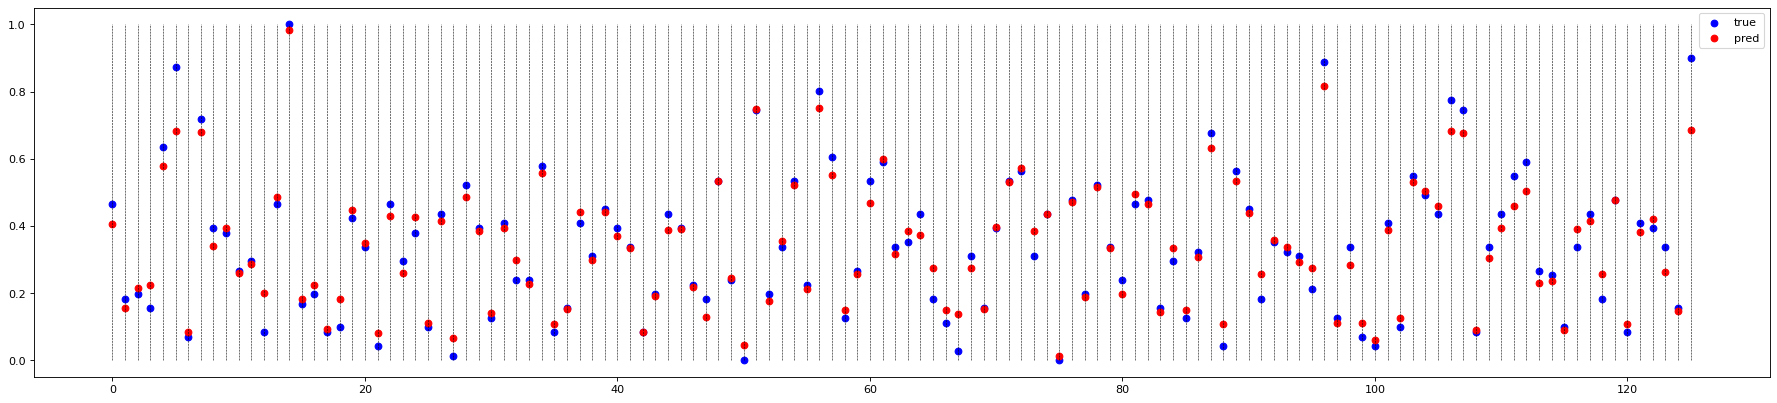

In [41]:
from matplotlib.pyplot import figure

figure(figsize=(28, 6), dpi=80)
plt.scatter(list(range(126)), y_test.ravel(), color="b", label="true")
plt.scatter(list(range(126)), predictions, color="r", label="pred")
for i in range(126):
    # plt.plot([i, i],[1,1], color='b')
    plt.vlines(x=i, ymin=0, ymax=1, colors='k', linestyles='--', lw=0.5)
plt.legend()
plt.show()